In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neural_network import MLPRegressor
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import r2_score,mean_absolute_error,mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler

In [3]:
#File Paths
input_file_path = '/home/zoro/Documents/ACMHackathon/device_data_model_input(device_data).csv'
target_file_path = '/home/zoro/Documents/ACMHackathon/device_data_model_target(poll_params).csv'
met_params_path = '/home/zoro/Documents/ACMHackathon/device_data_model_target(met_params).csv'

In [5]:
#Load Datasets
input_data = pd.read_csv(input_file_path)
target_data = pd.read_csv(target_file_path)
met_params_data = pd.read_csv(met_params_path)
input_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15840 entries, 0 to 15839
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   dt_time   15840 non-null  object 
 1   op1       15581 non-null  float64
 2   op2       15581 non-null  float64
 3   temp      15581 non-null  float64
 4   humidity  15581 non-null  float64
dtypes: float64(4), object(1)
memory usage: 618.9+ KB


In [7]:
# # Convert timestamp formats for consistency
input_data['dt_time'] = pd.to_datetime(input_data['dt_time'], format='%Y-%m-%d %H:%M:%S', errors='coerce')
target_data['dt_time'] = pd.to_datetime(target_data['dt_time'], errors='coerce')
met_params_data['dt_time'] = pd.to_datetime(met_params_data['dt_time'], errors='coerce')

/tmp/ipykernel_637550/3848064472.py:3: UserWarning: Parsing dates in %d-%m-%Y %H:%M:%S format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  target_data['dt_time'] = pd.to_datetime(target_data['dt_time'], errors='coerce')
/tmp/ipykernel_637550/3848064472.py:4: UserWarning: Parsing dates in %d-%m-%Y %H:%M:%S format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  met_params_data['dt_time'] = pd.to_datetime(met_params_data['dt_time'], errors='coerce')


In [9]:
# Merge datasets on 'dt_time' using inner joins
merged_data = pd.merge(input_data, target_data, on='dt_time', how='inner')
merged_data = pd.merge(merged_data, met_params_data, on='dt_time', how='inner')

In [11]:

# 1. Check for missing values before imputation
missing_values = merged_data.isnull().sum()
print("Missing values before imputation:\n", missing_values)

# 2. Apply advanced imputation if there are missing values
if missing_values.sum() > 0:
    # Linear interpolation for continuous time-series columns
    merged_data[['op1', 'op2', 'temp', 'humidity', 'ws', 'wd']] = merged_data[['op1', 'op2', 'temp', 'humidity', 'ws', 'wd']].interpolate(method='linear')
    
    # Forward-fill and backward-fill for remaining gaps (edge cases)
    merged_data.fillna(method='ffill', inplace=True)
    merged_data.fillna(method='bfill', inplace=True)

# 3. Verify that missing values are handled
missing_values_after = merged_data.isnull().sum()
print("Missing values after imputation:\n", missing_values_after)


Missing values before imputation:
 dt_time      0
op1         73
op2         73
temp        73
humidity    73
ozone       92
ws           0
wd           0
dtype: int64
Missing values after imputation:
 dt_time     0
op1         0
op2         0
temp        0
humidity    0
ozone       0
ws          0
wd          0
dtype: int64


/tmp/ipykernel_637550/3458433698.py:11: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  merged_data.fillna(method='ffill', inplace=True)
/tmp/ipykernel_637550/3458433698.py:12: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  merged_data.fillna(method='bfill', inplace=True)


In [13]:
#Extract temporal features from the datetime column
merged_data['hour'] = merged_data['dt_time'].dt.hour
merged_data['day_of_week'] = merged_data['dt_time'].dt.dayofweek
merged_data['month'] = merged_data['dt_time'].dt.month

# Interaction features (combining sensor outputs and environmental variables)
merged_data['op1_op2_ratio'] = merged_data['op1'] / (merged_data['op2'] + 1e-6)  # Avoid division by zero
merged_data['sensor_mean'] = (merged_data['op1'] + merged_data['op2']) / 2
merged_data['temp_humidity'] = merged_data['temp'] * merged_data['humidity']

#Meteorological Features
merged_data['THI'] = 0.8 * merged_data['temp'] + (merged_data['humidity'] / 100) * (merged_data['temp'] - 14.4) + 46.4

#Circular Feature Transformation (Categorical)
merged_data['wd_sin'] = np.sin(np.radians(merged_data['wd']))
merged_data['wd_cos'] = np.cos(np.radians(merged_data['wd']))

# Wind Vector Components (u and v)
merged_data['wind_u'] = merged_data['ws'] * np.cos(np.radians(merged_data['wd_cos']))
merged_data['wind_v'] = merged_data['ws'] * np.sin(np.radians(merged_data['wd_sin']))

# Lag Features (1-time step lag for op1, op2, temp, humidity, ozone)
merged_data['op1_lag1'] = merged_data['op1'].shift(1)
merged_data['op2_lag1'] = merged_data['op2'].shift(1)
merged_data['temp_lag1'] = merged_data['temp'].shift(1)
merged_data['humidity_lag1'] = merged_data['humidity'].shift(1)
merged_data['ozone_lag1'] = merged_data['ozone'].shift(1)

# Drop rows with missing values due to lagging
merged_data.dropna(inplace=True)

#Removing dt_time and wind direction as it is transformed
merged_data.drop(columns=['wd'], inplace=True)


In [15]:
#Outlier Detection
# Calculate IQR for ozone
Q1 = merged_data['ozone'].quantile(0.25)
Q3 = merged_data['ozone'].quantile(0.75)
IQR = Q3 - Q1

# Define bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Remove outliers
merged_data = merged_data[(merged_data['ozone'] >= lower_bound) & (merged_data['ozone'] <= upper_bound)]

# Reset index after removal
merged_data = merged_data.reset_index(drop=True)
z_scores = (merged_data['ozone'] - merged_data['ozone'].mean()) / merged_data['ozone'].std()
merged_data.loc[np.abs(z_scores) > 3, 'ozone'] = np.nan  # Remove extreme outliers

# 2. Identify and smooth step changes (flat lines)
threshold = 0.01  # Set threshold for detecting flat lines
step_mask = merged_data['ozone'].diff().abs() < threshold
merged_data.loc[step_mask, 'ozone'] = np.nan

# 3. Fill missing values after outlier removal using rolling window
merged_data['ozone'] = merged_data['ozone'].interpolate(method='linear')

<Figure size 1500x600 with 0 Axes>

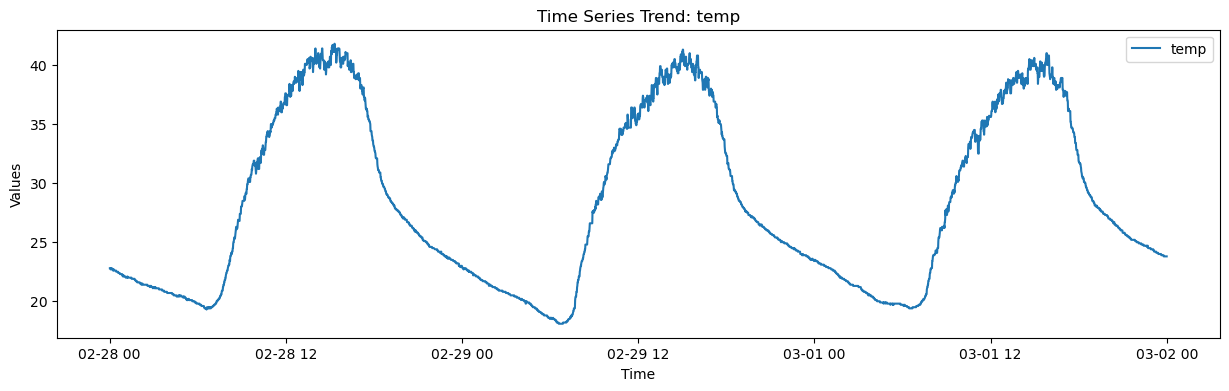

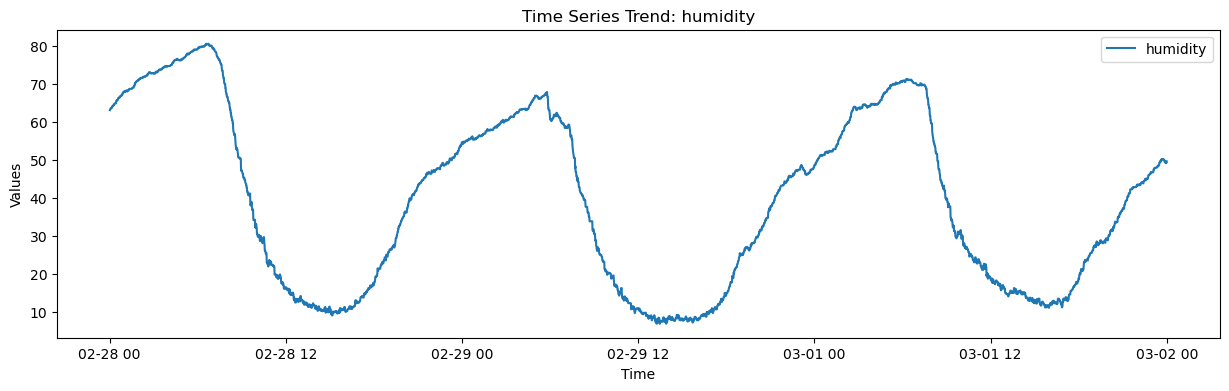

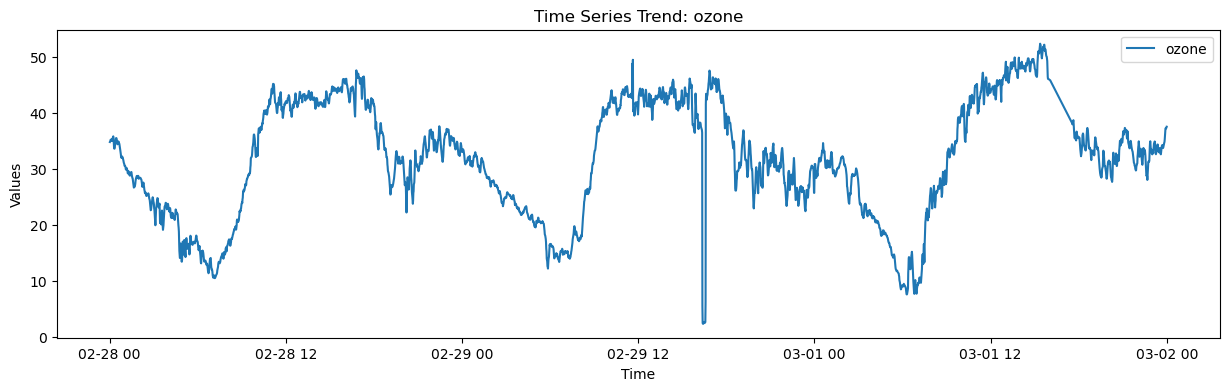

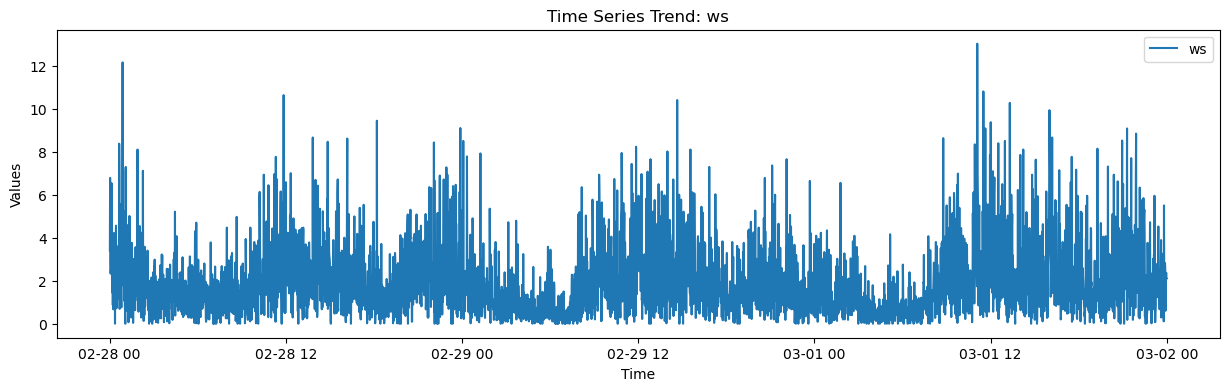

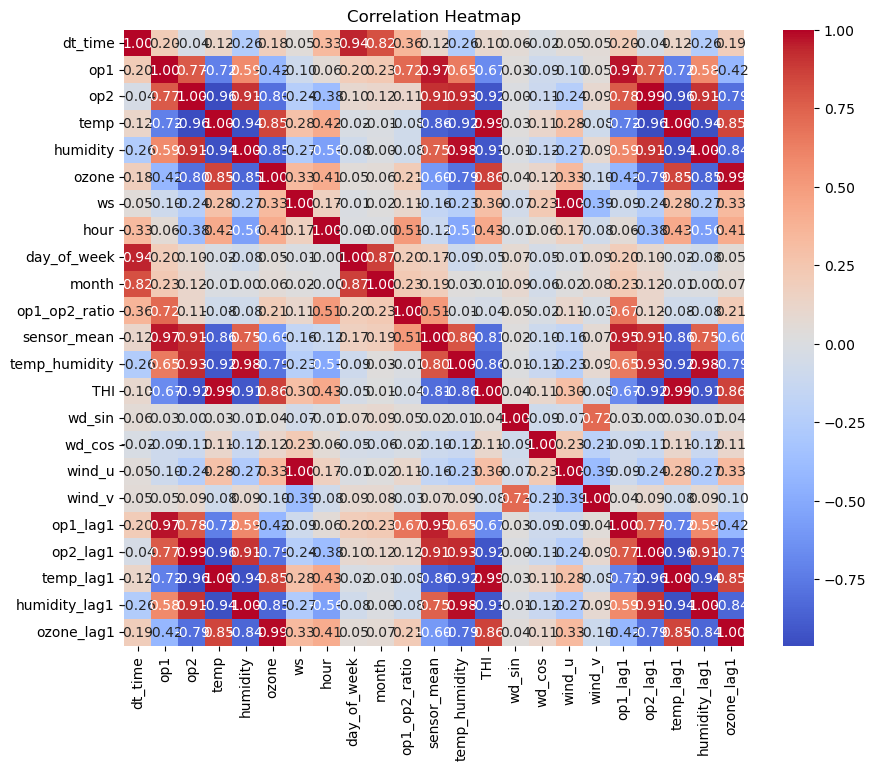

In [17]:
plt.figure(figsize=(15, 6))
columns_to_plot = ['temp', 'humidity', 'ozone', 'ws']
for column in columns_to_plot:
    plt.figure(figsize=(15, 4))
    plt.plot(merged_data['dt_time'], merged_data[column], label=column)
    plt.xlabel('Time')
    plt.ylabel('Values')
    plt.legend()
    plt.title(f'Time Series Trend: {column}')
    plt.show()

# Correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(merged_data.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()



In [47]:
selected_features = [
    'op1', 'op2', 'temp', 'ws', 'THI', 'wind_v', 'temp_lag1', 'humidity_lag1','ozone_lag1','op1_lag1','op2_lag1','humidity'
]
X = merged_data[selected_features]
y = merged_data['ozone']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [57]:
rfe_model = RandomForestRegressor(n_estimators=100, random_state=42)
rfe = RFE(estimator=rfe_model, n_features_to_select=4)
rfe.fit(X_train, y_train)
selected_features = X_train.columns[rfe.support_].tolist()
if 'op2' not in selected_features:
    selected_features.insert(0,'op2')
if 'op1' not in selected_features:
    selected_features.insert(0,'op1')
print("Selected Features:", selected_features)

Selected Features: ['op1', 'op2', 'temp', 'ws', 'THI', 'ozone_lag1']


In [59]:
scaler = StandardScaler()

# Fit only on training data
X_train_scaled = scaler.fit_transform(X_train[selected_features])
X_test_scaled = scaler.transform(X_test[selected_features])


In [63]:
nn_model = MLPRegressor(
    solver='adam', 
    max_iter=5000, 
    learning_rate_init=0.001, 
    hidden_layer_sizes=(256,128, 64),
    early_stopping=True, 
    batch_size=64, 
    alpha=0.00005, 
    activation='relu',
    random_state=42
)

# Train the model using the scaled training data (assuming X_train_scaled and y_train are defined)
nn_model.fit(X_train_scaled, y_train)

# Predictions on train and test data
y_train_pred = nn_model.predict(X_train_scaled)
y_test_pred = nn_model.predict(X_test_scaled)

# Calculate the evaluation metrics for the training set
train_mae = mean_absolute_error(y_train, y_train_pred)
train_rmse = mean_squared_error(y_train, y_train_pred, squared=False)
train_r2 = r2_score(y_train, y_train_pred)

# Calculate the evaluation metrics for the test set
test_mae = mean_absolute_error(y_test, y_test_pred)
test_rmse = mean_squared_error(y_test, y_test_pred, squared=False)
test_r2 = r2_score(y_test, y_test_pred)
test_mape = (abs(y_test - y_test_pred) / y_test).mean() * 100

# Check for overfitting (based on R², RMSE, and MAE)
overfitting_flag = (
    (train_r2 - test_r2 > 0.05) or 
    (train_rmse < test_rmse * 0.8) or 
    (train_mae < test_mae * 0.8)
)

# Store the results in a dictionary
metrics_nn = {
    'Train R²': train_r2, 'Test R²': test_r2,
    'Train RMSE': train_rmse, 'Test RMSE': test_rmse,
    'Train MAE': train_mae, 'Test MAE': test_mae,
    'Test MAPE': test_mape,
    'Overfitting': 'Yes' if overfitting_flag else 'No'
}

# Print the evaluation metrics for the Neural Network
print(metrics_nn)

{'Train R²': 0.9786686125177575, 'Test R²': 0.9787233843183499, 'Train RMSE': 1.4918418732615055, 'Test RMSE': 1.4958723549341368, 'Train MAE': 0.6973508799253384, 'Test MAE': 0.7047055863530878, 'Test MAPE': 3.770450326795315, 'Overfitting': 'No'}


/home/zoro/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/home/zoro/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [69]:
import numpy as np

# Given parameters
temp = 26.9
ws = 1.66
humidity = 41
ozone_lag1 = 33.17
op2 = 231
op1 = 263

# Calculate THI
THI = 0.8 * temp + (humidity * (temp - 14.4)) / 100 + 46.4

# Prepare input features
input_features = np.array([[op1,op2,temp, ws, THI, ozone_lag1]])

# Scale input if needed
input_scaled = scaler.transform(input_features)  # Remove if not using a scaler

# Predict Ozone Value
predicted_ozone = nn_model.predict(input_scaled)[0]

print(f"Predicted Ozone Value: {predicted_ozone}")


Predicted Ozone Value: 33.52591175125484


/home/zoro/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
